Step 1: Setting up the Colab Environment

In [ ]:
# Mount Google Drive to save data
from google.colab import drive
drive.mount('/content/drive')

# Install necessary libraries
!pip install pandas matplotlib scikit-learn tensorflow torch


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Step 2: Download and Prepare Dataset


In [ ]:
import pandas as pd
import zipfile
import os

# Unzip the dataset (adjust path based on your Drive structure)
zip_path = '/content/drive/My Drive/CMAPSSData.zip'
data_folder = '/content/drive/My Drive/CMAPSSData'

if not os.path.exists(data_folder):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_folder)

print("Dataset extracted successfully!")


Dataset extracted successfully!


Step 3: Data Loading and Exploration
python
Copy code


In [ ]:
# Load a dataset file (FD001 is commonly used for testing)
file_path = '/content/drive/My Drive/CMAPSSData/test_FD001.txt'

# Column names for the dataset
columns = ['unit_number', 'time_in_cycles'] + [f'operational_setting_{i}' for i in range(1, 4)] + \
          [f'sensor_measurement_{i}' for i in range(1, 22)]

# Load the data
data = pd.read_csv(file_path, sep=' ', header=None, names=columns, engine='python')
data = data.dropna(axis=1)  # Remove unnamed empty columns

print(data.head())


     unit_number  time_in_cycles  operational_setting_1  \
1 1       0.0023          0.0003                  100.0   
  2      -0.0027         -0.0003                  100.0   
  3       0.0003          0.0001                  100.0   
  4       0.0042          0.0000                  100.0   
  5       0.0014          0.0000                  100.0   

     operational_setting_2  operational_setting_3  sensor_measurement_1  \
1 1                 518.67                 643.02               1585.29   
  2                 518.67                 641.71               1588.45   
  3                 518.67                 642.46               1586.94   
  4                 518.67                 642.44               1584.12   
  5                 518.67                 642.51               1587.19   

     sensor_measurement_2  sensor_measurement_3  sensor_measurement_4  \
1 1               1398.21                 14.62                 21.61   
  2               1395.42                 14.62 

Step 4: Preprocessing

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Calculate the Remaining Useful Life (RUL)
def add_rul(df):
    # Get the maximum time_in_cycles for each unit
    max_cycles = df.groupby('unit_number')['time_in_cycles'].transform('max')
    # Calculate RUL using transform to align with original DataFrame
    df['RUL'] = max_cycles - df['time_in_cycles']
    return df

data = add_rul(data)

# Normalize sensor data
sensor_columns = [col for col in data.columns if 'sensor_measurement' in col]
scaler = MinMaxScaler()
data[sensor_columns] = scaler.fit_transform(data[sensor_columns])

print(data.head())

     unit_number  time_in_cycles  operational_setting_1  \
1 1       0.0023          0.0003                  100.0   
  2      -0.0027         -0.0003                  100.0   
  3       0.0003          0.0001                  100.0   
  4       0.0042          0.0000                  100.0   
  5       0.0014          0.0000                  100.0   

     operational_setting_2  operational_setting_3  sensor_measurement_1  \
1 1                 518.67                 643.02              0.421968   
  2                 518.67                 641.71              0.504025   
  3                 518.67                 642.46              0.464814   
  4                 518.67                 642.44              0.391587   
  5                 518.67                 642.51              0.471306   

     sensor_measurement_2  sensor_measurement_3  sensor_measurement_4  \
1 1              0.282214                   0.0                   1.0   
  2              0.225240                   0.0 

Step 5: Model Development in PyTorch

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# Define a custom PyTorch Dataset
class CMAPSSDataset(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length
        self.unit_numbers = data['unit_number'].unique()

    def __len__(self):
        return len(self.unit_numbers)

    def __getitem__(self, idx):
        unit_data = self.data[self.data['unit_number'] == self.unit_numbers[idx]]
        sensor_data = unit_data[sensor_columns].values
        rul = unit_data['RUL'].values
        return torch.tensor(sensor_data[-self.sequence_length:], dtype=torch.float32), \
               torch.tensor(rul[-1], dtype=torch.float32)

# Prepare PyTorch DataLoader
sequence_length = 30
dataset = CMAPSSDataset(data, sequence_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define an LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h, _ = self.lstm(x)
        return self.fc(h[:, -1, :])

# Initialize model, loss, and optimizer
input_size = len(sensor_columns)
hidden_size = 64
num_layers = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Step 6: Model Development in TensorFlow

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Input

# Define a TensorFlow model
tf_model = Sequential([
       Input(shape=(sequence_length, len(sensor_columns))),
       LSTM(64, activation='relu', return_sequences=False),
       Dense(1)
   ])

tf_model.compile(optimizer='adam', loss='mse')

# Prepare TensorFlow Dataset
def create_tf_dataset(data, sequence_length):
    features, labels = [], []
    for unit_number in data['unit_number'].unique():
        unit_data = data[data['unit_number'] == unit_number]
        sensor_data = unit_data[sensor_columns].values
        rul = unit_data['RUL'].values
        for i in range(len(sensor_data) - sequence_length + 1):
            features.append(sensor_data[i:i+sequence_length])
            labels.append(rul[i+sequence_length-1])
    return tf.data.Dataset.from_tensor_slices((features, labels)).batch(32)

tf_dataset = create_tf_dataset(data, sequence_length)


Step 7: Training the Models

PyTorch Training Loop:

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np  # Import numpy for padding

epochs = 10

class CMAPSSDataset(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length
        self.unit_numbers = data['unit_number'].unique()

        # Calculate maximum sequence length
        self.max_sequence_length = max(len(self.data[self.data['unit_number'] == unit_num]) for unit_num in self.unit_numbers)
        # Update sequence length if calculated max sequence length is shorter than sequence_length
        self.sequence_length = min(self.sequence_length, self.max_sequence_length)



    def __len__(self):
        return len(self.unit_numbers)

    def __getitem__(self, idx):
        unit_data = self.data[self.data['unit_number'] == self.unit_numbers[idx]]
        sensor_data = unit_data[sensor_columns].values
        rul = unit_data['RUL'].values

        # Pad sensor data if sequence is shorter than sequence_length
        if len(sensor_data) < self.sequence_length:
            padding_shape = (self.sequence_length - len(sensor_data), sensor_data.shape[1])
            padded_sensor_data = np.concatenate([np.zeros(padding_shape), sensor_data], axis=0)
        else:
            padded_sensor_data = sensor_data[-self.sequence_length:]

        # Pad RUL values to match sensor data
        # (only necessary if sequence_length is shorter than maximum sequence length)
        if len(rul) < self.sequence_length:
            padded_rul = np.concatenate([np.zeros(self.sequence_length - len(rul)), rul], axis=0)
        else:
            padded_rul = rul[-self.sequence_length:]


        return torch.tensor(padded_sensor_data, dtype=torch.float32), \
               torch.tensor(padded_rul[-1], dtype=torch.float32)  # Take the last RUL value


# Re-initialize the dataset and dataloader with padding
dataset = CMAPSSDataset(data, sequence_length)  # Use the updated CMAPSSDataset
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Now you can proceed with training
for epoch in range(epochs):
    for batch_features, batch_labels in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs.squeeze(), batch_labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")



Epoch 1/10, Loss: 0.0003196786274202168
Epoch 2/10, Loss: 0.0011126822791993618
Epoch 3/10, Loss: 0.00012354865611996502
Epoch 4/10, Loss: 0.00044280357542447746
Epoch 5/10, Loss: 9.336092625744641e-05
Epoch 6/10, Loss: 9.12937757675536e-05
Epoch 7/10, Loss: 5.608332867268473e-05
Epoch 8/10, Loss: 4.759913736052113e-06
Epoch 9/10, Loss: 2.803814822982531e-05
Epoch 10/10, Loss: 5.917232101637637e-06


TensorFlow Training:

In [ ]:
tf_model.fit(tf_dataset, epochs=10)


Epoch 1/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 2.8304e-04
Epoch 2/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 1.1217e-05
Epoch 3/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 5.0269e-06
Epoch 4/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 2.5554e-06
Epoch 5/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 1.4104e-06
Epoch 6/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 1.2574e-06
Epoch 7/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 1.4877e-06
Epoch 8/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 1.1928e-06
Epoch 9/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 9.2468e-07
Epoch 10/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 1.1739e-06


# Step 8: Evaluation

Evaluate PyTorch Model

In [ ]:
# Evaluate PyTorch Model
def evaluate_model_pytorch(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_features, batch_labels in dataloader:
            outputs = model(batch_features)
            loss = criterion(outputs.squeeze(), batch_labels)
            total_loss += loss.item()
    return total_loss / len(dataloader)

# Create a DataLoader for evaluation
test_dataset = CMAPSSDataset(data.sample(frac=0.2), sequence_length)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate
pytorch_loss = evaluate_model_pytorch(model, test_dataloader, criterion)
print(f"PyTorch Model Test Loss: {pytorch_loss}")


PyTorch Model Test Loss: 9.810692677092448e-06


Evaluate TensorFlow Model


In [ ]:
# Evaluate TensorFlow Model
def evaluate_model_tensorflow(tf_model, dataset):
    total_loss = 0
    for features, labels in dataset:
        predictions = tf_model(features)
        loss = tf.keras.losses.MeanSquaredError()(labels, predictions)
        total_loss += loss.numpy()
    return total_loss / len(dataset)

# Evaluate
tf_loss = evaluate_model_tensorflow(tf_model, tf_dataset)
print(f"TensorFlow Model Test Loss: {tf_loss}")


TensorFlow Model Test Loss: 3.0715308931796206e-07


Predict with PyTorch


In [ ]:
# Predict with PyTorch
pytorch_predictions = []
pytorch_labels = []
model.eval()
with torch.no_grad():
    for batch_features, batch_labels in test_dataloader:
        outputs = model(batch_features)
        pytorch_predictions.extend(outputs.squeeze().numpy())
        pytorch_labels.extend(batch_labels.numpy())


Predit with TensorFlow

In [ ]:
# Predict with TensorFlow
tf_predictions = []
tf_labels = []
for features, labels in tf_dataset:
    predictions = tf_model(features)
    tf_predictions.extend(predictions.numpy().flatten())
    tf_labels.extend(labels.numpy())



# Step 9: Visualization

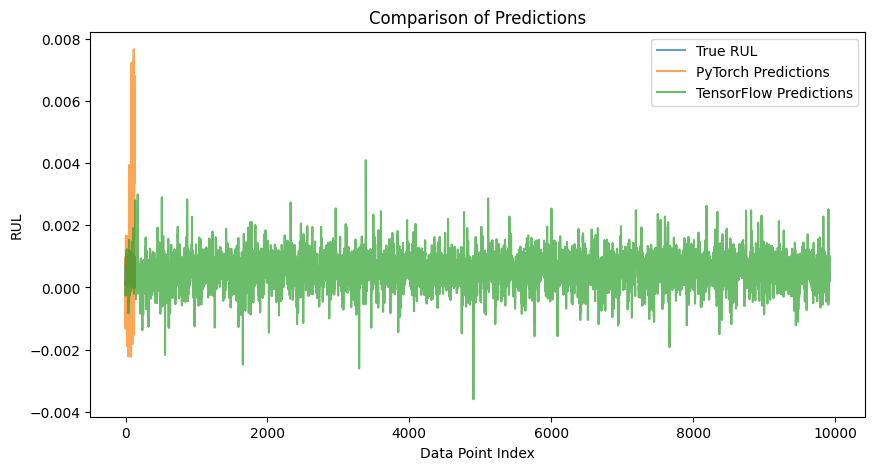

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(pytorch_labels, label='True RUL', alpha=0.7)
plt.plot(pytorch_predictions, label='PyTorch Predictions', alpha=0.7)
plt.plot(tf_predictions, label='TensorFlow Predictions', alpha=0.7)
plt.legend()
plt.title('Comparison of Predictions')
plt.xlabel('Data Point Index')
plt.ylabel('RUL')
plt.show()